In [61]:
import pymc as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

In [62]:
# read
n_LF, n_HF, rel_error = np.loadtxt('error_function.txt', unpack=True, usecols=(0,1,2))

In [63]:
# extract n_LF < 60
'''n_LF_thres = 60
n_LF_new = []
n_HF_new = []
rel_err_new = []
for i in range(len(n_LF)):
    if n_LF[i] < n_LF_thres:
        n_LF_new.append(n_LF[i])
        n_HF_new.append(n_HF[i])
        rel_err_new.append(rel_error[i])
n_LF = np.array(n_LF_new)
n_HF = np.array(n_HF_new)
rel_error = np.array(rel_err_new)'''

'n_LF_thres = 60\nn_LF_new = []\nn_HF_new = []\nrel_err_new = []\nfor i in range(len(n_LF)):\n    if n_LF[i] < n_LF_thres:\n        n_LF_new.append(n_LF[i])\n        n_HF_new.append(n_HF[i])\n        rel_err_new.append(rel_error[i])\nn_LF = np.array(n_LF_new)\nn_HF = np.array(n_HF_new)\nrel_error = np.array(rel_err_new)'

In [64]:
error_mean = rel_error.mean()
error_var = np.var(rel_error)

In [65]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    eta = pm.Normal("eta", mu=error_mean, sigma=np.sqrt(error_var))
    '''rho = pm.Uniform("rho", lower=0, upper=10)
    beta_L = pm.Uniform("beta_L", lower=0, upper=3)
    beta_H = pm.Uniform("beta_H", lower=0, upper=6)'''
    rho = pm.LogNormal("rho", mu=0, sigma=1)
    beta_L = pm.LogNormal("beta_L", mu=0, sigma=1)
    beta_H = pm.LogNormal("beta_H", mu=0, sigma=1)
    
    sigma = pm.HalfNormal("sigma", sigma=.1)

    # Expected value of outcome
    mu = eta * (rho * n_LF**(-beta_L) + n_HF**(-beta_H))

    # Likelihood (sampling distribution) of observations
    rel_error_obs = pm.Normal("rel_error_obs", mu=mu, sigma=sigma, observed=rel_error)

In [66]:
error_mean

0.04611004135185185

In [67]:
with basic_model:
    # draw 2000 posterior samples
    # idata = pm.sample(2000, tune=1000)
    idata = pm.sample(3000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eta, rho, beta_L, beta_H, sigma]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 278 seconds.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.


In [68]:
dict(idata)

{'posterior': <xarray.Dataset>
 Dimensions:  (chain: 4, draw: 3000)
 Coordinates:
   * chain    (chain) int64 0 1 2 3
   * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 2993 2994 2995 2996 2997 2998 2999
 Data variables:
     eta      (chain, draw) float64 0.1168 0.1277 0.1744 ... 0.1263 0.1669 0.1271
     rho      (chain, draw) float64 5.987 5.638 4.025 3.913 ... 5.334 4.089 5.802
     beta_L   (chain, draw) float64 0.6415 0.645 0.6241 ... 0.6336 0.6468 0.6459
     beta_H   (chain, draw) float64 2.285 1.947 2.659 2.507 ... 2.067 2.277 2.27
     sigma    (chain, draw) float64 0.03843 0.03803 0.03929 ... 0.03837 0.03768
 Attributes:
     created_at:                 2023-08-30T21:53:19.922184
     arviz_version:              0.16.1
     inference_library:          pymc
     inference_library_version:  5.7.2
     sampling_time:              278.0878162384033
     tuning_steps:               1000,
 'sample_stats': <xarray.Dataset>
 Dimensions:                (chain: 4, draw: 3000)
 Coordinates

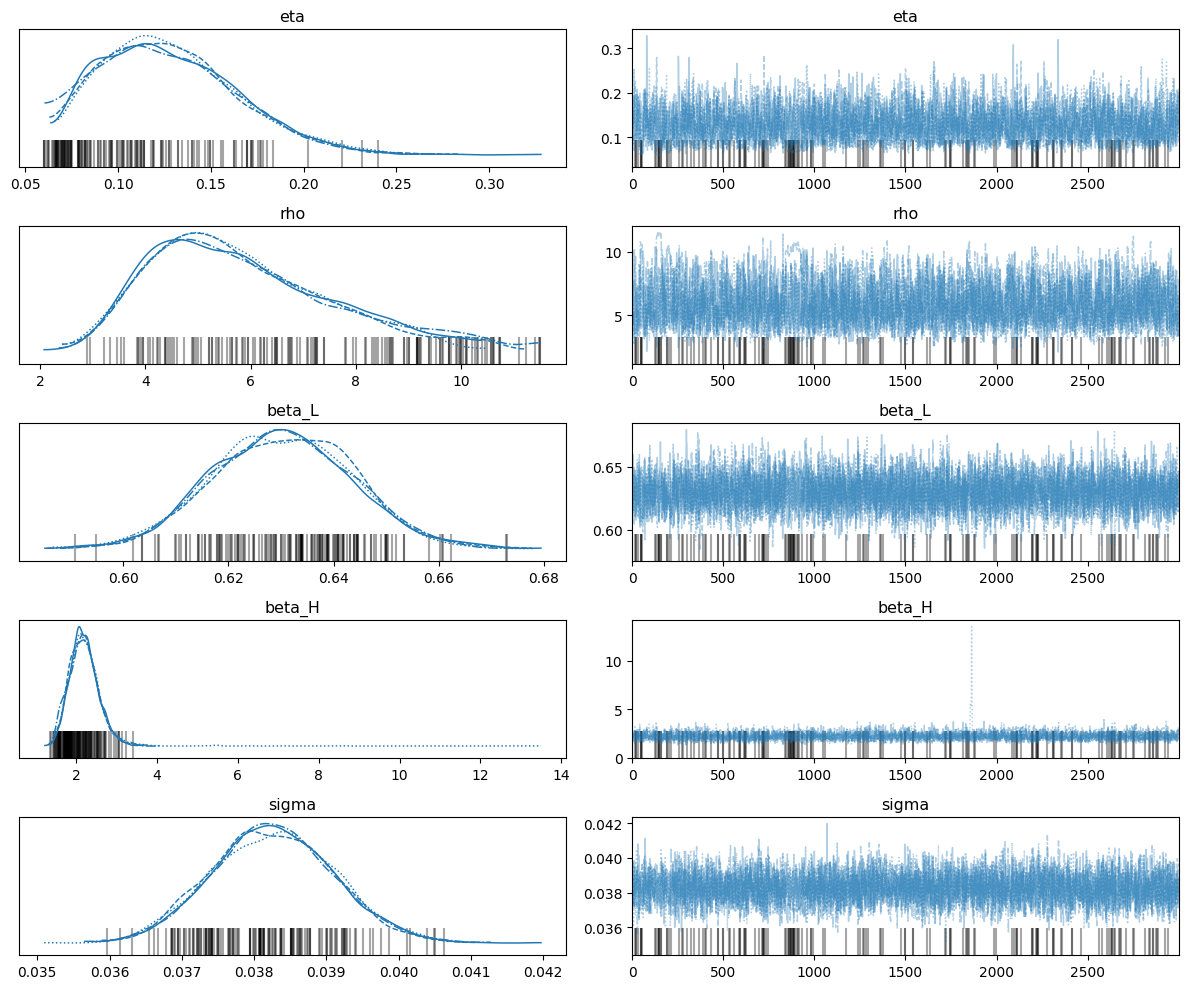

In [69]:
az.plot_trace(idata)
plt.tight_layout()

In [70]:
posterior_eta = idata["posterior"]["eta"]
credible_interval_eta = np.percentile(posterior_eta, [16, 50, 84])
posterior_rho = idata["posterior"]["rho"]
credible_interval_rho = np.percentile(posterior_rho, [16, 50, 84])
posterior_beta_L = idata["posterior"]["beta_L"]
credible_interval_beta_L = np.percentile(posterior_beta_L, [16, 50, 84])
posterior_beta_H = idata["posterior"]["beta_H"]
credible_interval_beta_H = np.percentile(posterior_beta_H, [16, 50, 84])
print(credible_interval_eta)
print(credible_interval_rho)
print(credible_interval_beta_L)
print(credible_interval_beta_H)


[0.08982507 0.12420984 0.16526   ]
[4.14176123 5.53945717 7.68271895]
[0.61695175 0.63021449 0.64367828]
[1.8482887  2.17635687 2.53318023]


In [71]:
az.summary(idata, round_to=3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
eta,0.128,0.037,0.066,0.193,0.001,0.001,1829.451,541.262,1.002
rho,5.836,1.723,3.062,9.213,0.046,0.039,1765.457,535.180,1.002
beta_L,0.630,0.013,0.605,0.655,0.000,0.000,4849.943,5950.754,1.001
beta_H,2.205,0.387,1.549,2.841,0.008,0.006,2816.851,2153.319,1.001
sigma,0.038,0.001,0.037,0.040,0.000,0.000,4764.191,5507.725,1.000


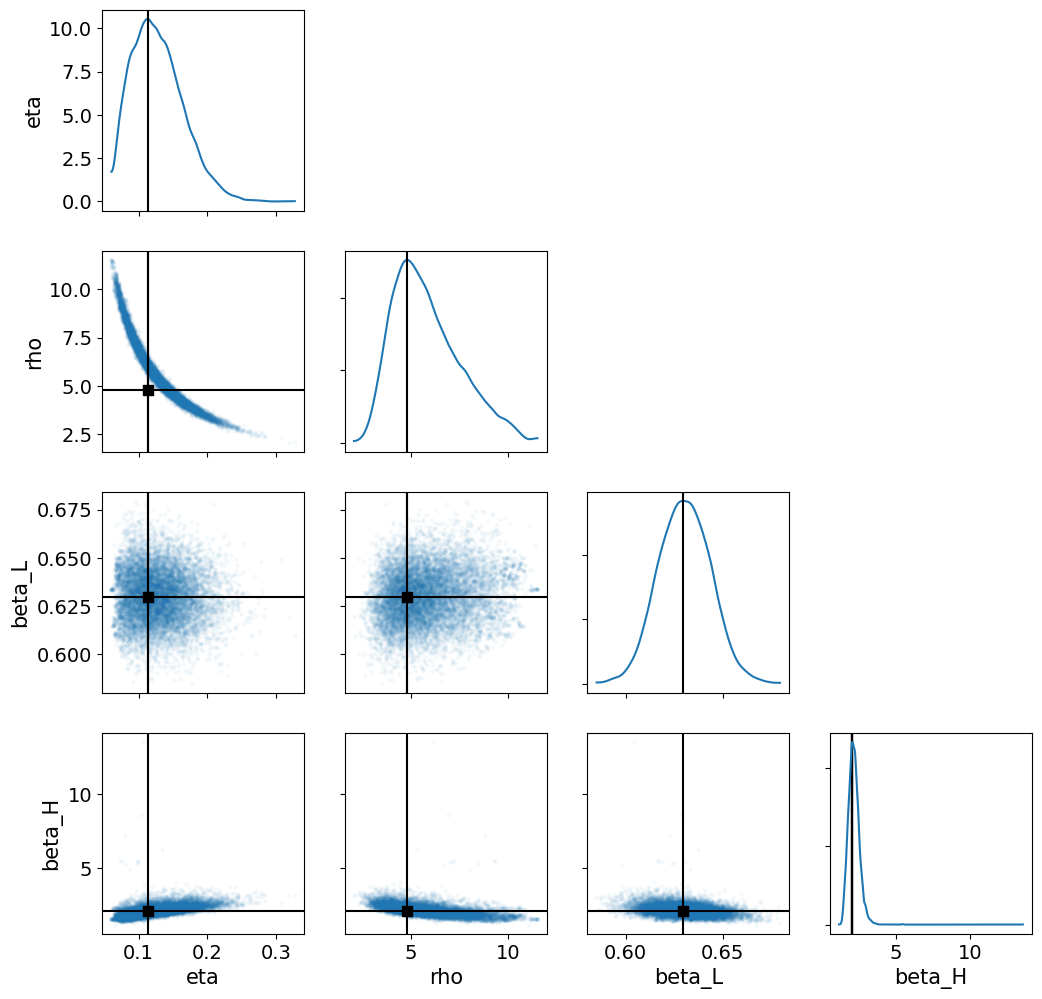

In [76]:
az.plot_pair(
    idata,
    marginals=True,
    point_estimate="median",
    figsize=(12, 12),
    scatter_kwargs={"alpha": 0.05},
    var_names=["eta", "rho", "beta_L", "beta_H"],
);

In [78]:
# loss  mean
eta_mean = np.mean(idata["posterior"]["eta"].values)
rho_mean = np.mean(idata["posterior"]["rho"].values)
beta_L_mean = np.mean(idata["posterior"]["beta_L"].values)
beta_H_mean = np.mean(idata["posterior"]["beta_H"].values)

phi = eta_mean * (rho_mean * n_LF**(-beta_L_mean) + n_HF**(-beta_H_mean))
loss = np.mean((phi - rel_error)**2)

In [79]:
loss

0.0014869597942432618

In [80]:
# loss  median
eta_median = .124
rho_median = 5.539
beta_L_median = .630
beta_H_median = 2.176

phi = eta_median * (rho_median * n_LF**(-beta_L_median) + n_HF**(-beta_H_median))
loss = np.mean((phi - rel_error)**2)

In [81]:
loss

0.001456487316995252

In [75]:
type(idata["posterior"]["eta"])

xarray.core.dataarray.DataArray